##  DNA curtain finder part 3
----

This notebook is the final in the series of three `DNA_curtain_finder` notebooks. This notebook finishes describing the method we use to fit the intensity of each DNA strand to determine its length and position. This notebook begins where `DNA_curtain_finder_2` left off, and, here, like on the last notebook, the first thing we'll do is bring in the three definitions from `DNA_curtain_finder_part_1` and `DNA_curtain_finder_part_2`, as well as two new aptly named definitions of gaussians:
* find_rotang
* find_curtain
* find_DNA
* mundane_gauss_function
* super_gauss_function

In [1]:
#Dependencies
import toolbox.alignment as al
from skimage.external.tifffile import imread
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line
from skimage.morphology import dilation,square
from skimage.exposure import equalize_adapthist
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from scipy.ndimage.interpolation import rotate


import os
import numpy as np
import matplotlib.pyplot as plt

#- this is here to suppress Optimization 
#- warnings from curve_fit. 
import warnings
warnings.filterwarnings('ignore')

def super_gauss_function(x, floor, amplitude, mean, sigma, power):
    return floor + amplitude*np.exp((-((x-mean)**2/(2*sigma**2))**power))

def mundane_gauss_function(x, floor, amplitude, mean, sigma):
    return floor + amplitude*np.exp((-((x-mean)**2/(2*sigma**2))))

def find_rotang(Image, line_length = 40,
                theta = None, line_gap = 5, tilt = .1):
    if theta is None:
        theta = np.linspace(np.pi/2.-tilt, np.pi/2.+tilt, 500)
        
    edges = canny(equalize_adapthist(Image))
    lines = probabilistic_hough_line(edges,line_length=line_length,
                                     theta=theta,line_gap=line_gap)
    
    rise = [line[1][1]-line[0][1] for line in lines]
    run = [line[1][0]-line[0][0] for line in lines]
    rotation = 180*np.tan(np.mean(rise)/np.mean(run))/np.pi
    return rotation



def find_curtain(Image, distance = 50, line_length = 40, 
                   theta = None, line_gap = 5, tilt = .1, 
                   window = 15, order = 3, maxline = 70):

    if theta is None:
        theta = np.linspace(np.pi/2.-tilt, np.pi/2.+tilt, 500)
        
    edges = canny(equalize_adapthist(Image))
    lines = probabilistic_hough_line(edges,line_length=line_length,
                                     theta=theta,line_gap=line_gap)
    
    line_starts = [line[0][0] for line in lines]
    line_ends = [line[1][0] for line in lines]
    x = np.linspace(0,Image.shape[1]+1,Image.shape[1]+1)
    starts,bins = np.histogram(line_starts,bins=x)
    ends,bins = np.histogram(line_ends,bins=x)
    smoothed_starts = savgol_filter(starts, window, order)
    smoothed_ends = savgol_filter(ends, window, order)
    peaks_start, _ = find_peaks(smoothed_starts, distance = distance)
    peaks_end, _ = find_peaks(smoothed_ends, distance = distance)
    curtains = []
    for j in peaks_start:
        for k in peaks_end:
            if (abs(j-k)>line_length and abs(j-k)<line_length+20 
                and smoothed_starts[j]>1. and smoothed_ends[k]>1.):
                curtains.append((j,k))    
    d = {key[0]:[] for key in curtains}
    for line in lines:
        key = min(peaks_start, key=lambda x:abs(x-line[0][0]))
        if line[1][0]-line[0][0]<maxline:
            try:
                d[key].append(line[0][1])
            except KeyError:
                pass
    data = []
    curtain_mask = np.ones_like(Image, dtype=bool)
    for m, n in zip(d, curtains):
        x_min = min(np.clip([n[0]-10], 0, rotated_ch2.shape[1]))
        x_max = max(np.clip([n[1]+10], 0, rotated_ch2.shape[1]))
        y_min = min(np.clip([x-5 for x in d[m]], 0, rotated_ch2.shape[0]))
        y_max = max(np.clip([x+5 for x in d[m]], 0, rotated_ch2.shape[0]))
        
        data.append((x_min, x_max, y_min, y_max))
        curtain_mask[y_min:y_max,x_min:x_max] = False

    return data, curtain_mask



def find_DNA(Image, Bounds, prominence = None):
    
    data = []
    point_im = np.zeros_like(Image, dtype=bool)
    for i in range(Image.shape[1]):
        subim = Image[:,i]
        peaks, properties = find_peaks(subim)
        for j in peaks:
            point_im[j,i]=True   
    detected_im = np.zeros_like(Image, dtype=bool)
    for i in Bounds:
        subarr = point_im[i[2]:i[3],i[0]:i[1]]
        flattened_arr = [sum(subarr[j,:]) for j in range(len(subarr))]
        if prominence is None:
            prominence = (20, 1.5*max(flattened_arr))
        peaks, properties = find_peaks(flattened_arr, distance = 3, prominence = prominence)
        for j in peaks:
            data.append((i[0],i[1],i[2]+j))     
    return data


Next, lets make sure everything works.

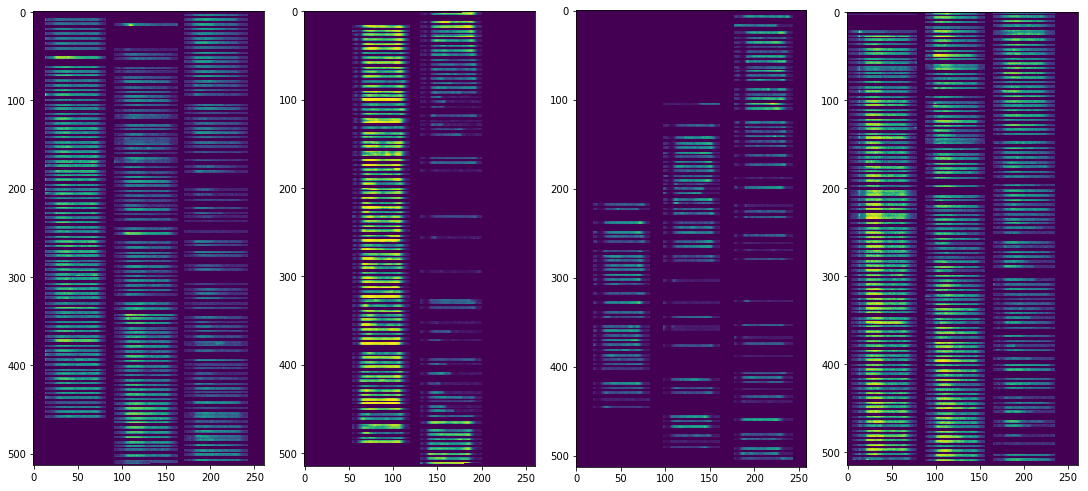

In [2]:
im_list = []
for i in os.listdir("test_images/"):
    if i.endswith("tif"):
        im_list.append(imread("test_images/"+i))

fig, subplots = plt.subplots(1,4,figsize=(15,10),
                             constrained_layout=True)

for i, ax in zip(im_list, subplots.reshape(-1)):
    ch1,ch2 = al.im_split(i)
    angle = find_rotang(ch2)
    rotated_ch2 = rotate(ch2,angle)
    bounds, mask = find_curtain(rotated_ch2)
    strands = find_DNA(rotated_ch2,bounds)
    detected_im = np.zeros_like(rotated_ch2, dtype=bool)
    for j in strands:
        detected_im[j[2],j[0]:j[1]] = True
    rotated_ch2 = equalize_adapthist(rotated_ch2)
    rotated_ch2[np.invert(dilation(detected_im,square(3)))] = 0
    ax.imshow(rotated_ch2)

Alright, looks cool. The stratagy for this notebook will be to grab the local pixels around each DNA identified by `find_DNA` and fit that signal in the `x` and `y` dimensions. Along the long axis of the DNA we are going to fit with a [super gaussian function](https://en.wikipedia.org/wiki/Gaussian_function#Higher-order_Gaussian_or_super-Gaussian_function). Then on the short axis we will fit with a mundane guassian. We will do a little selection here also. Along the DNA axis, we can select for lengths based on a minimum allowed value. On the other axis we will select based on how well the fit does.

Okay, lets get started and grab the local pixels around each DNA from one of our images to see how they look.

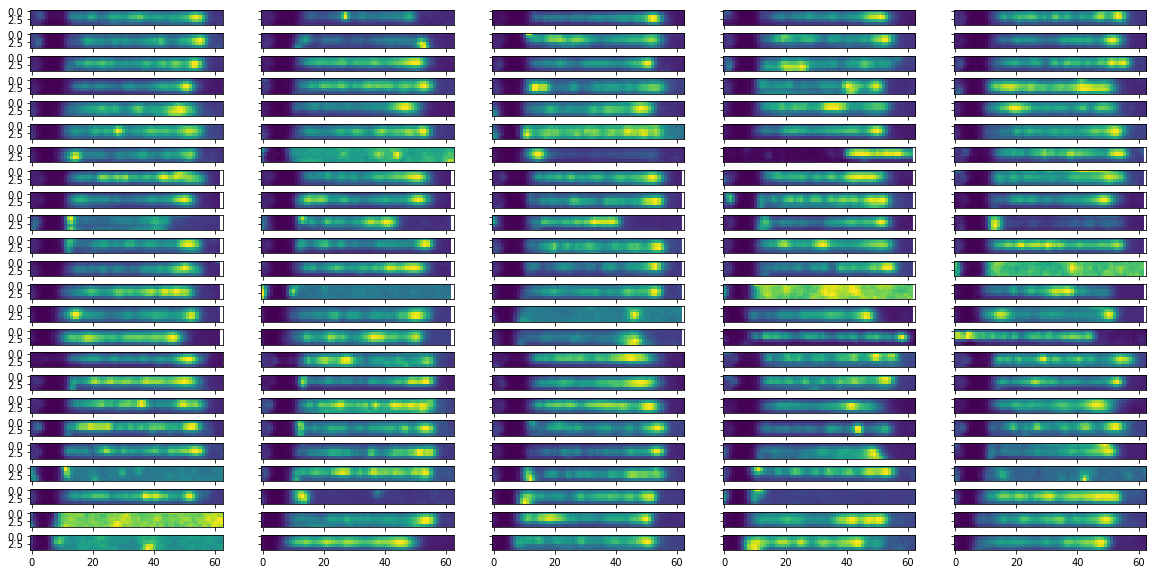

In [3]:
ch1,ch2 = al.im_split(im_list[2])
angle = find_rotang(ch2)
rotated_ch2 = rotate(ch2,angle)
bounds, mask = find_curtain(rotated_ch2)
strands = find_DNA(rotated_ch2,bounds)


fig, subplots = plt.subplots(int(len(strands)/5),5,figsize=(20,10),
                             sharex = True, sharey = True)
pad = 2
for i,ax in zip(strands,subplots.reshape(-1)):
    if i[2]-pad<0:
        pass
    elif i[2]+pad+1>rotated_ch2.shape[0]:
        pass
    else:
        ax.imshow(rotated_ch2[i[2]-pad:i[2]+pad+1,i[0]:i[1]])

        
plt.show()

I'm going to start with by fitting the length. As we do it, a couple things are going to happen.
* First we will grab (2 $\times$ pad + 1) pixel wide stripe of the image based on the output of `find_DNA`, just like we did right above.
* Then we will average this image along its short axis
* We then fit that intensity with the super guassian, and strictly require the power to be greater than 5

Then we want to assign a value to the start and end position of the DNA based on this fit. As of yet we have not determined the best way to do this. Here, we assign a height threshold to define the edges of the DNA. In the future, I would love to benchmark this with dCas9 binding, but for now the routine is:
* Define threshold as a fractional amount of the maximum height.
* Then find the intersection of our fit and that threshold value, **and** require it crosses twice 
* Finally, we require the absolute distance between the two intersections be larger than our allowed minimum.


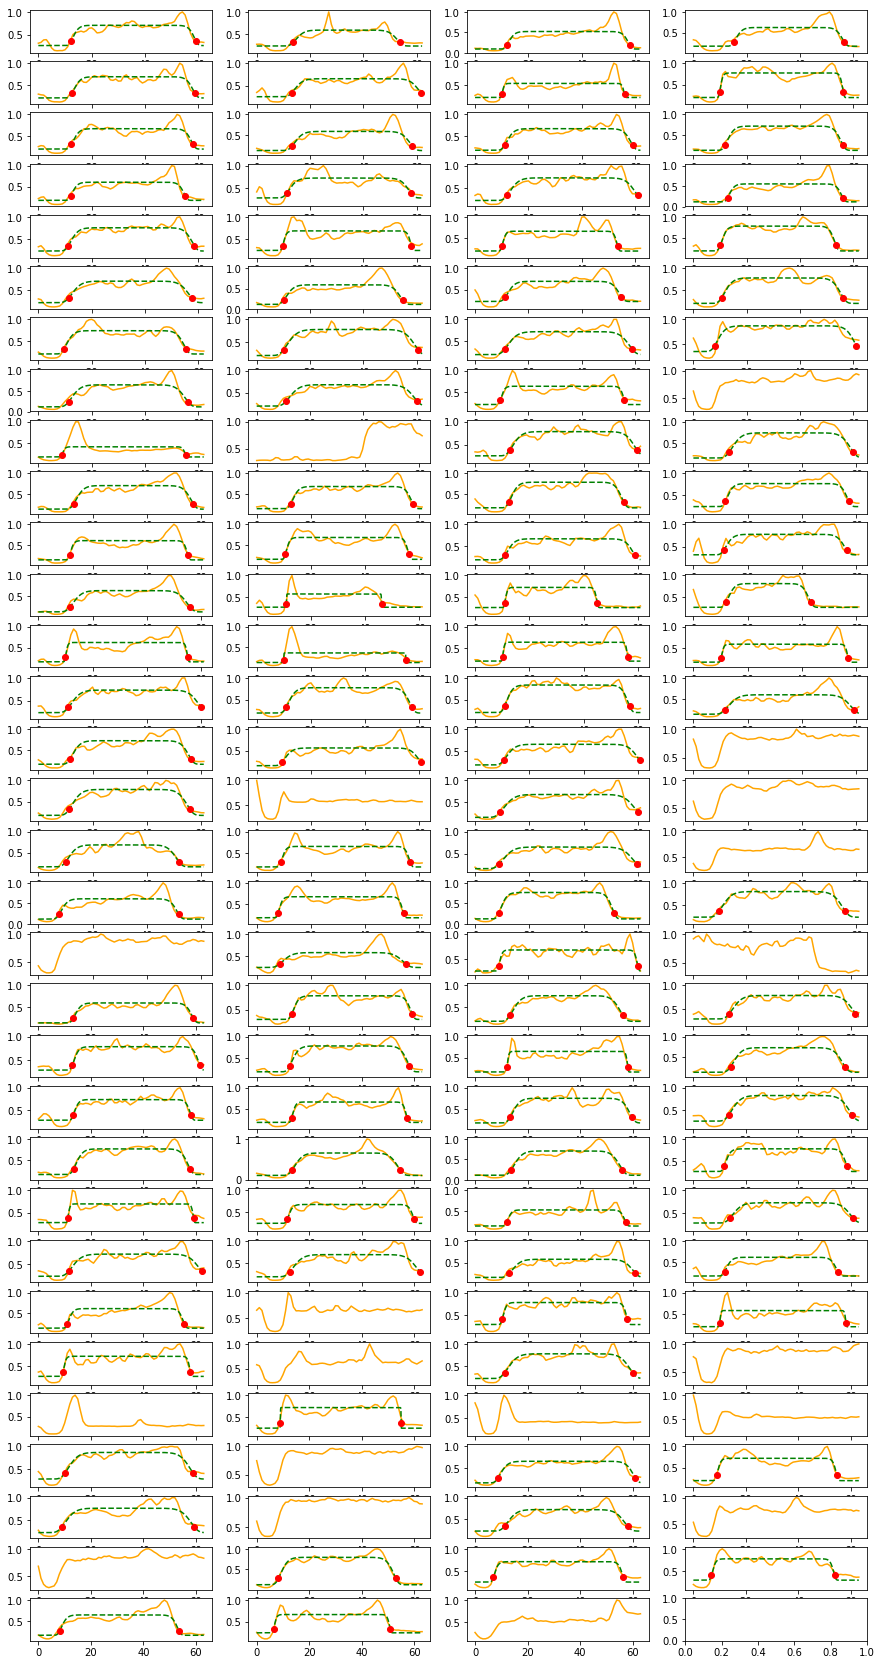

In [4]:
ch1,ch2 = al.im_split(im_list[2])
angle = find_rotang(ch2)
rotated_ch2 = rotate(ch2,angle)
bounds, mask = find_curtain(rotated_ch2)
strands = find_DNA(rotated_ch2,bounds)

pad =2
fig, subplots = plt.subplots(int(len(strands)/4),4,figsize=(15,30))
for i,ax in zip(strands,subplots.reshape(-1)):
    #-- toss out DNA too close to the edge of the image
    if i[2]-pad<0 or i[2]+pad+1>rotated_ch2.shape[0]:
        pass
    else:    
        local_dna = rotated_ch2[i[2]-pad:i[2]+pad+1,i[0]:i[1]]
        average_intensity = local_dna.mean(axis=0)
        normed_dna = np.array([float(value)/max(average_intensity) for value in average_intensity])
        xdata = np.array([j for j in range(len(normed_dna))])
        ax.plot(xdata,normed_dna, 'orange')
        
        initial_guess = [.2,1.,np.median(xdata),20, 6]
        #Here's where we force the power to be >=5
        constraints =([0, 0, 0, 0, 5.],[np.inf, np.inf, np.inf, np.inf, np.inf])
        try:
            popt, pcov = curve_fit(super_gauss_function, xdata, normed_dna,
                                   p0 = initial_guess, bounds = constraints)
            #--- this is here to increase the resolution at which we
            #--- can move along our fit to find the edges.
            fine_scale_x = np.linspace(xdata[0],xdata[-1],len(xdata)*1000)
            maximum = max(super_gauss_function(xdata, *popt))
            #--- this is the threshold
            intersection_value = maximum-(maximum - popt[0])/1.3  
            linedata = [intersection_value for x in fine_scale_x]
            index = np.argwhere(np.diff(np.sign(linedata - super_gauss_function(fine_scale_x, *popt)))).flatten()
            #-- Here is where we ensure two crossings and select for length
            if len(index)==2 and fine_scale_x[index[1]]-fine_scale_x[index[0]] > 30: 
                ax.plot(fine_scale_x, super_gauss_function(fine_scale_x, *popt), 'g--')
                ax.plot([fine_scale_x[index[0]],fine_scale_x[index[1]]],
                        super_gauss_function([fine_scale_x[index[0]],fine_scale_x[index[1]]], *popt), 'ro')
            else:
                pass
        except RuntimeError:
            pass

        
plt.show()

I think these fits are pretty good, and so on to the other axis. Here the plan is exactly as above, only we average in the other direction and fit with the `mundane_guassian_function`. Also, for these fits, we will select by how confident we are in the estimation of the mean value, and apply a maximum allowed standard deviation. 

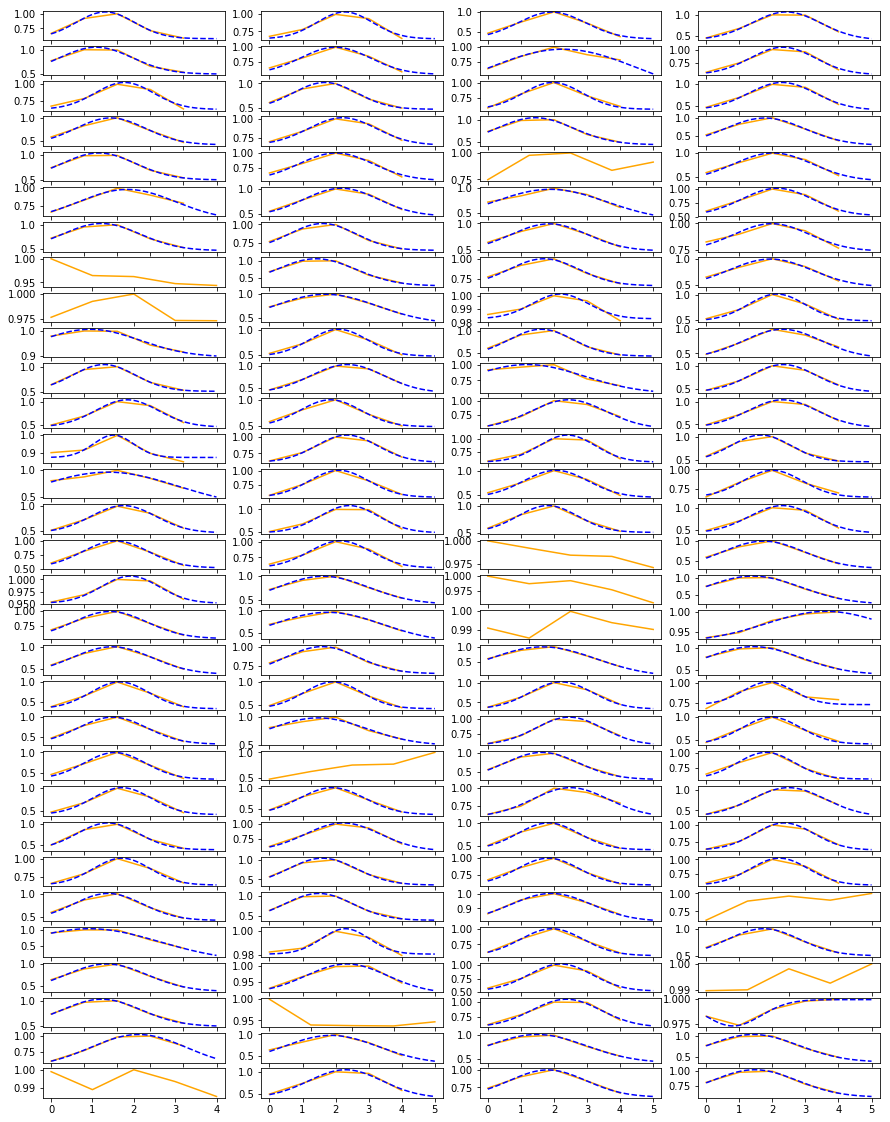

In [5]:
ch1,ch2 = al.im_split(im_list[2])
angle = find_rotang(ch2)
rotated_ch2 = rotate(ch2,angle)
bounds, mask = find_curtain(rotated_ch2)
strands = find_DNA(rotated_ch2,bounds)

pad = 2
fig, subplots = plt.subplots(int(len(strands)/4),4,figsize=(15,20))
for i,ax in zip(strands,subplots.reshape(-1)):
    if i[2]-pad<0 or i[2]+pad+1>rotated_ch2.shape[0]:
        pass
    else:
        local_dna = rotated_ch2[i[2]-pad:i[2]+pad+1,i[0]:i[1]]
        average_intensity = local_dna.mean(axis=1)
        normed_dna = np.array([float(value)/max(average_intensity) for value in average_intensity])
        xdata = [z for z in range(len(normed_dna))]
        fit_x = np.linspace(0,len(normed_dna),1000)
        ax.plot(normed_dna, "orange")
        try:
            popt, pcov = curve_fit(mundane_gauss_function, xdata, normed_dna,
                                   p0 = [1,1,2,1])
            #-- here's the selection
            #-- if the error on the mean value is more than 30%
            #-- of the mean, then we toss it out.
            #-- also we toss if the standard deviation is higher than 3 pixels
            if np.sqrt(pcov[2][2])/popt[2] < .3 and popt[3] < 3:
                ax.plot(fit_x,mundane_gauss_function(fit_x, *popt), "b--")
            else:
                pass        
        except RuntimeError:
            pass

Fucking great. Both of these fitting routines look like they are doing what we want now, so I am going to wrap everything up into a single definition.

In [6]:
def fit_DNA(Image, locations, constraints = None, 
            init_guess_length = None, init_guess_center = None,
            pad = 2, factor = 1.3, min_length = 45,
            cen_err = .3, cen_dev = 3):
    
    if constraints is None:
        constraints =([0, 0, 0, 0, 5.], 
                      [np.inf, np.inf, np.inf, np.inf, np.inf])
    output = []
    for i in locations:  
        if i[2]-pad<0 or i[2]+pad+1>rotated_ch2.shape[0]:
            pass
        else:    
            local_dna = rotated_ch2[i[2]-pad:i[2]+pad+1,i[0]:i[1]]
            #----------------------------------------------------#
            #-----------------fit the DNA length-----------------#
            #----------------------------------------------------#
            average_intensity = local_dna.mean(axis=0)
            normed_dna = np.array([float(value)/max(average_intensity) for value in average_intensity])
            xdata = np.array([j for j in range(len(normed_dna))])
            if init_guess_length is None: 
                init_guess_length = [.2,1.,np.median(xdata),20, 6]
            try:
                popt, pcov = curve_fit(super_gauss_function, xdata, normed_dna,
                                       p0 = init_guess_length, bounds = constraints)
                fine_scale_x = np.linspace(xdata[0],xdata[-1],len(xdata)*1000)
                maximum = max(super_gauss_function(fine_scale_x, *popt))
                intersection_value = maximum-(maximum - popt[0])/factor  
                linedata = [intersection_value for x in fine_scale_x]
                index = np.argwhere(np.diff(np.sign(linedata - super_gauss_function(fine_scale_x, *popt)))).flatten()
                if len(index)==2:
                    if fine_scale_x[index[1]]-fine_scale_x[index[0]] > min_length:
                        top = i[0]+fine_scale_x[index[0]]
                        bottom = i[0]+ fine_scale_x[index[1]]
                    else:
                        top = None
                        bottom = None
                else:
                    top = None
                    bottom = None
            except RuntimeError:
                top = None
                bottom = None
 
            #----------------------------------------------------#
            #-----------------fit the DNA center-----------------#
            #----------------------------------------------------#
            average_intensity = local_dna.mean(axis=1)
            normed_dna = np.array([float(value)/max(average_intensity) for value in average_intensity])
            xdata = np.array([j for j in range(len(normed_dna))])
            if init_guess_center is None: 
                init_guess_center = [1,1,2,1]
            try:
                popt, pcov = curve_fit(mundane_gauss_function, xdata, normed_dna,
                                       p0 = init_guess_center)
                if np.sqrt(pcov[2][2])/popt[2] < cen_err and popt[3] < cen_dev:
                    center = i[2] - 2.5 + popt[2]
                else:
                    center = None
            except RuntimeError:
                center = None
            if all((top,bottom,center)):
                output.append((top,bottom,center))
    return output
            
    
    

Okay, now `fit_DNA` returns a list of tuples with the (top, bottom, and center) of each DNA. Below shows the usage of the definitions we have made throughout the `DNA_curtain_finder` notebooks.

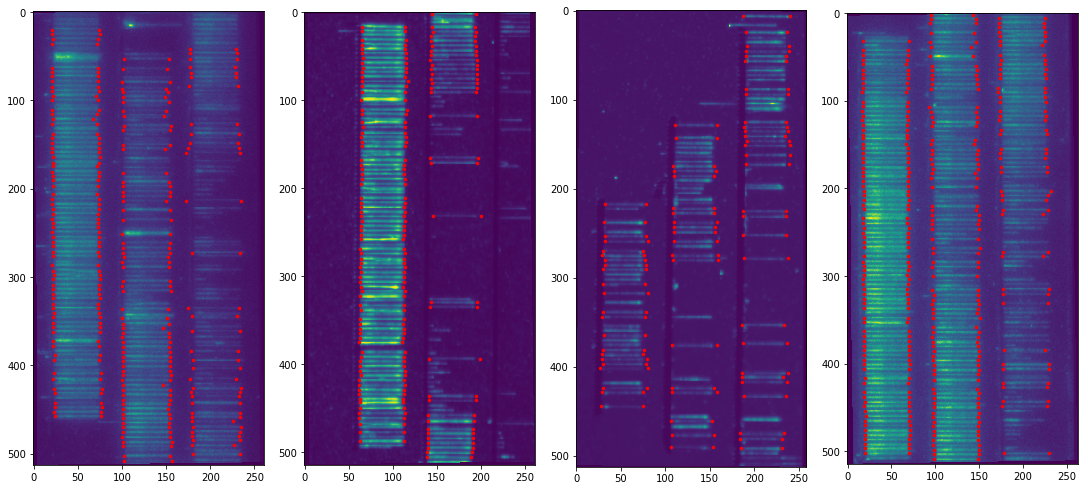

In [7]:
im_list = []
for i in os.listdir("test_images/"):
    if i.endswith("tif"):
        im_list.append(imread("test_images/"+i))

fig, subplots = plt.subplots(1,4,figsize=(15,10),
                             constrained_layout=True)

for i, ax in zip(im_list, subplots.reshape(-1)):
    
    ch1,ch2 = al.im_split(i)
    angle = find_rotang(ch2)
    rotated_ch2 = rotate(ch2,angle)
    bounds, mask = find_curtain(rotated_ch2)
    strands = find_DNA(rotated_ch2,bounds)
    DNAs = fit_DNA(rotated_ch2, strands)

    ax.imshow(rotated_ch2)
    for x0,x1,y in DNAs:
        ax.plot([x0,x1],[y,y],"r.", markersize = 5)